In [1]:
import pandas as pd
import numpy as np
import os

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    data_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-02-02-2022.xlsx'),skiprows= 1 )
        
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET",'Vt'])
        temp_data = temp_data[temp_data['Pressure']>0.01]
        #temp_data = temp_data[temp_data['Vmic']<2]
        index = list(set(temp_data['Index'].values))
        #print(len(index))
        #test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
        #train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
        #test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
        
        #train_df = pd.concat([train_df,train_x],axis=0)
        data_df = pd.concat([data_df,temp_data],axis =0)
    return data_df

In [253]:
data = pred_dataset(['Methane']) #'Ethane&Ethylene'

In [310]:
from sklearn.decomposition import KernelPCA,SparsePCA
from sklearn.preprocessing import MinMaxScaler

In [287]:
total_feature = ["Index",'BET','Vt','Temp(K)']
pca_feature =  ['BET','Vt','Temp(K)']
sub_data = data[total_feature].drop_duplicates()
sub_data_scalered = MinMaxScaler().fit_transform(sub_data[pca_feature].values)
kernel_pca = KernelPCA(kernel='poly',max_iter =1000000,n_jobs =-1,gamma=1e-2,fit_inverse_transform=True)
sparce_pca = SparsePCA(max_iter=1000000)
kernel_pca.fit(sub_data_scalered,)

KernelPCA(fit_inverse_transform=True, gamma=0.01, kernel='poly',
          max_iter=1000000, n_jobs=-1)

In [ ]:
# saprce_pca
total_feature = ["Index",'BET','Vt','Temp(K)']
pca_feature =  ['BET','Vt','Temp(K)']
sub_data = data[total_feature].drop_duplicates()
sub_data_scalered = MinMaxScaler().fit_transform(sub_data[pca_feature].values)
sparce_pca = SparsePCA(max_iter=1000000)
sparce_pca.fit(sub_data_scalered,)
num_feature = 3
sub_data_transformed = sparce_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
reconstructed = sparce_pca.inverse_transform(sub_data_transformed.reshape(num_feature,-1))
mean_squared_error(sub_data_scalered,reconstructed.reshape(-1,num_feature))

In [288]:
# for cfcs only
total_feature = ["Index",'BET','Vt','Temp(K)']
pca_feature =  ['BET','Vt','Temp(K)']
sub_data = data[total_feature].drop_duplicates()
sub_data_scalered = MinMaxScaler().fit_transform(sub_data[pca_feature].values)
kernel_pca = KernelPCA(kernel='poly',max_iter =1000000,n_jobs =-1,gamma=1e-3,fit_inverse_transform=True)
kernel_pca.fit(sub_data_scalered,)
num_feature = 3

In [289]:
sub_data_transformed = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
reconstructed = kernel_pca.inverse_transform(sub_data_transformed.reshape(num_feature,-1))

In [290]:
mean_squared_error(sub_data_scalered,reconstructed.reshape(-1,num_feature))

0.03137681913977072

In [291]:
from sklearn.metrics import mean_squared_error
mses = []
for i in range(len(sub_data_scalered)):
    mses.append(mean_squared_error(sub_data_scalered[i],reconstructed.reshape(-1,num_feature)[i]))

(array([448., 152.,  62.,  62.,  26.,  33.,  18.,  10.,   4.,   5.]),
 array([0.00026518, 0.0189685 , 0.03767182, 0.05637514, 0.07507845,
        0.09378177, 0.11248509, 0.13118841, 0.14989172, 0.16859504,
        0.18729836]),
 <BarContainer object of 10 artists>)

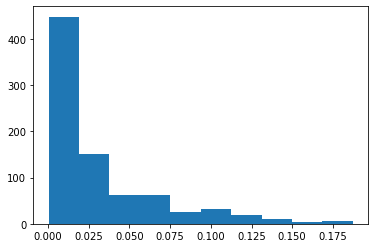

In [292]:
import matplotlib.pyplot as plt

plt.hist(mses)

In [293]:
df_mse = pd.DataFrame(mses,columns = ['MSE'])
df_mse['Indexs'] = sub_data["Index"].drop_duplicates().values
df_mse.to_csv('./Methane_3_kernel_pca_re_mse.csv')

In [302]:
index_removed = df_mse[df_mse["MSE"]>0.15]["Indexs"].values.tolist()  # for E&E >0.16,methane>0.125
len(index_removed)

9

In [303]:
index_removed

[2783, 2784, 2942, 2943, 3199, 3236, 3237, 3546, 3547]

# training models

In [304]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
from sklearn.svm import SVR
  
n_estimators = [50,100,120,150,180,200]

# define different models#,
models = [
    #('SVR',SVR(max_iter=100000)),
    #('DT',DecisionTreeRegressor(random_state=42)),\
    # ('ADBR',AdaBoostRegressor(random_state=42)), 
    ("GBR",GradientBoostingRegressor(random_state=42)),\
    #('BG',BaggingRegressor(random_state=42,n_jobs=-1)),
    ('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
    #('RF',RandomForestRegressor(n_jobs=-1,random_state=42)),
    ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),\
    ('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators = 200, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1)),\
    #('BGETR',BaggingRegressor(ExtraTreesRegressor(n_estimators = 180,random_state=42,n_jobs=6),random_state=42,n_jobs=-1))
    ]

# set search parameters grid for different models
para_grids = { 
    'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
    'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,50],'learning_rate': [0.05,0.1,0.5,1],'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,30,50]},\
    'BGETR':{'n_estimators':[10]}
    }

In [305]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle

def model_CV(train_x,train_y,groups,model,para_grid):

    out_cv = GroupKFold(n_splits = 5)
    result = GridSearchCV(model,para_grid,cv= out_cv.get_n_splits(groups =groups),
    scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    
    model_refit =model.set_params(**result.best_params_)
    train_cv = cross_validate(model_refit,train_x,train_y,groups = groups,cv =out_cv,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    
    return [train_r2_cv,train_mse_cv],result.best_params_

# model evaluation
def model_eval(model,test_x,test_y):
      
    test_pre = model.predict(test_x)
    test_r2 = r2_score(test_pre,test_y)
    test_mse = mean_squared_error(test_y,test_pre)
    return test_r2,test_mse

# comparing different models
def model_comparison(model_list,para_grids,feature_list,gas_list):
    gas_list = gas_list 
    input_feature = feature_list
    output = ['Adsorp(mmol/g)']
    result_total = []

    for gas in gas_list:
        
        if gas =='total':

            train_df_com = train_df
            test_df_com = test_df
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index'].values
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
            
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2_total,test_mse_total = model_eval(model_refit,test_x,test_y.squeeze()) 
                for gases in gas_list[1:]:
                    test_df_com = test_df[test_df['Label']==gases]
                    test_xs = test_df_com[input_feature]
                    test_ys = test_df_com[output].values
                    test_r2,test_mse = model_eval(model_refit,test_xs,test_ys.squeeze()) 
                    result_total.append([gases,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])

                    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))    
        
        else:
            train_df_com = train_df[train_df['Label']==gas]
            test_df_com = test_df[test_df['Label']==gas]
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index']
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
           
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2,test_mse = model_eval(model_refit,test_x,test_y.squeeze()) 
                result_total.append([gas,model_name+'_separate',result[0],result[1],-1,-1, test_r2,test_mse,best_param])
                
                print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))

                
    return result_total

In [306]:
def data_split(df,removed_index = None):
    if removed_index!= None:
        temp_data = df.loc[~df["Index"].isin(removed_index)]
    else: temp_data = df
    index = list(set(temp_data['Index'].values))
    print(len(index))
    test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
    train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
    test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
    return train_x,test_x

In [307]:
import os
base_feature = ['V','S','L','BET',]
condition_feature = ['Temp(K)','Pressure']
combin_1 = ['Vt']
combin_2 = ["Vmeso"]
combin_3 = ['Vmic']
combin_4 = ['Vt',"Vmeso",]
combin_3 = ['Vt',"Vmic",]
combin_5 = ['Vt',"Vmic",'Vmeso',]
combin_6 = ["Vmic",'Vmeso',]
feature_list = [base_feature+condition_feature,base_feature+combin_1+condition_feature,]
columns = ['Gas','Model_name','CV_r2','CV_mse','test_r2_total_model','test_mse_by_total_model','test_r2_separa_model','test_mse_separa_model','best_param']

file_name = ['BET_only','BET_plut_Vt']
feature_set = ["BET","Vt",]
gas_list = ['Methane']
for i in range(15):
    train_df,test_df = data_split(data,removed_index=index_removed)
    
    for j in range(len(feature_list)):
        results = model_comparison(models,para_grids, feature_list[j],gas_list)
        files_name = 'BG_ETR_Full_Four_gases_with_pred_Vmic_'+file_name[j]+'_result_'+str(i)+'.csv'
        pd.DataFrame(results,columns = columns).to_csv(os.path.join('./5_kernel_pca',files_name))  

811
Dataset Methane, Algorithm GBR_total, Test_r2 0.9142490075563979, Test_error 1.0116228644980803
Dataset Methane, Algorithm ETR_total, Test_r2 0.9068250685501814, Test_error 1.1194044294063417
Dataset Methane, Algorithm LGBM_total, Test_r2 0.8915231013472694, Test_error 1.3486760227196866
Dataset Methane, Algorithm BGLGBM_total, Test_r2 0.9049775003183599, Test_error 1.1491813230705032
Dataset Methane, Algorithm GBR_total, Test_r2 0.9180637042606855, Test_error 1.0206826475505226
Dataset Methane, Algorithm ETR_total, Test_r2 0.9231789887448738, Test_error 0.9422731441548672
Dataset Methane, Algorithm LGBM_total, Test_r2 0.913370236775298, Test_error 1.0715869860487786
Dataset Methane, Algorithm BGLGBM_total, Test_r2 0.9264762502113203, Test_error 0.8854381901544065
811
Dataset Methane, Algorithm GBR_total, Test_r2 0.8801405357957912, Test_error 1.116227187515909
Dataset Methane, Algorithm ETR_total, Test_r2 0.8386700890858959, Test_error 1.4041377909597574
Dataset Methane, Algorithm

In [308]:
import pandas as pd
file_name = ['BET_only','BET_plut_Vt']
df_list = []
cal_columns= ["CV_r2","CV_mse","test_r2_separa_model","test_mse_separa_model"] 
for j in range(len(file_name)):
    for i in range(15):
    
        files_name = 'BG_ETR_Full_Four_gases_with_pred_Vmic_'+file_name[j]+'_result_'+str(i)+'.csv'
        df_list.append(pd.read_csv(os.path.join('./5_kernel_pca',files_name))[cal_columns] )
        pd.concat(df_list).groupby(level=0).mean().to_csv(os.path.join('./5_kernel_pca',file_name[j]+'_mean.csv'))
        pd.concat(df_list).groupby(level=0).std().to_csv(os.path.join('./5_kernel_pca',file_name[j]+'_std.csv'))